### 此notebook旨在帮助理解isophote，及使用isophote来分析星系的星系。在北京大学CSST暑期学校实践操作课堂使用。由Si-Yue Yu所写，电子邮件：syu@mpifr-bonn.mpg.de
### 更多信息查看：https://photutils.readthedocs.io/en/stable/isophote.html  
### 官方的例子：https://github.com/astropy/photutils-datasets/tree/main/notebooks/isophote   

In [1]:
from astropy.io import fits
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from photutils.isophote import EllipseGeometry
from photutils.isophote import Ellipse
from photutils import EllipticalAperture
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import HistEqStretch, LogStretch
import time
import matplotlib.patches as patches
from photutils.isophote import build_ellipse_model
from astropy.wcs import WCS
from extract_fix_isophotes import extract_fix_isophotes
import copy
plt.style.use('classic')
plt.rc('font', family='Times New Roman')

In [2]:
path_img = 'NGC628_i.fits'
path_mask = 'myNGC628_i_mask.fits'

### 先用ds9看看该星系的形态结构及mask（谨记，python的数组是从0开始计的，但是ds9，是从1开始的）：

In [6]:
!ds9 NGC628_i.fits # 或者!open NGC628_i.fits     "!"带终端的命令比如，!ls 可执行改命令

# 把鼠标移动到星系的（大概）中心，可以读出中心的大概位置：x=1124, y=1124。在现实的应用场景中，你往往通过一些catalog知道了星系中心的位置，那么用这个位置即可。观察这个星系还可以发现，ngc628占的pixel数目很多，星系的半径看起来有700个pixels以上。在现实的应用场景中，你可以通过一些程序先估算这个星系的大小。

In [7]:
hdu = fits.open(path_img)[0]  # 读取 NGC628 的成像数据，为SDSS i band的数据。
img = hdu.data
mask = fits.getdata(path_mask) #读取 mask，mask用来避免foreground stars的影响。

img_masked = np.ma.array(img, mask=mask) # 利用mask来做一个masked array，作为photutils.isophote.Ellipse的输入
DIM = img.shape[0] # 星系的中心大概在图片的中间，DIM用来估算星系中心的。在你自己的应用场景中，你得确定你的星系中心大概也放在图片中间才可使用
DIM

2247

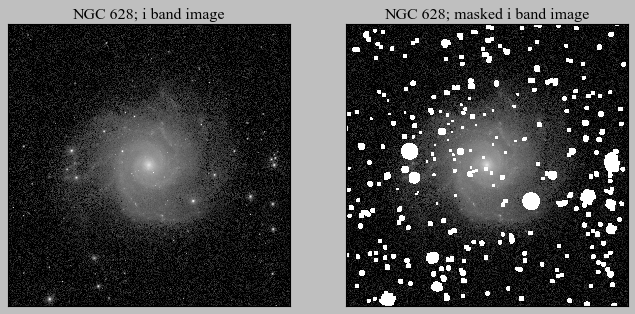

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
plt.imshow(img, origin='lower', cmap='Greys_r', norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('NGC 628; i band image')

plt.subplot(122)
norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
plt.imshow(img_masked, origin='lower', cmap='Greys_r', norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('NGC 628; masked i band image')

plt.savefig('NGC628_mask.png', bbox_inches='tight')

# 第一次拟合isophotes。我们通过这次拟合来确定星系的中心。

In [12]:
# 初始参数设置。关于e0, pa0, sma0的设置，可用ds9打开图像估算一下。pixscl 为 pixel scale，即一个pixel的张角。
# 这里使用的是SDSS的图像，1 pixel = 0.396 arcsec
params = {}
params['e0'] = 0.1       # 这个星系看起来比较面向我们，取一个较小的值就可以了
params['pa0'] = 10       # 这个看不准，可以设置为 0
params['sma0'] = 200     # 我们刚才用ds9打开图像的时候，能知道这个图比较大，sma0一般设置一个不大不小的值就可以，
# 但是如果photutils跑不出结果，很可能在这个sma0的结构太混乱，被误认为是噪声，这时候就得换一个sma0
params['xcen0'] = int(DIM/2) # 星系的中心在图片中间附近，但是你们的作业的星系图片的中心并不是星系中心，你们用ds9打开，查看中心在哪
params['ycen0'] = int(DIM/2) #
params['pixscl'] = 0.396  

In [13]:
time_start = time.time()

geometry = EllipseGeometry(params['xcen0'], params['ycen0'], params['sma0'], params['e0'], params['pa0'])

ellipse = Ellipse(img_masked, geometry)

iso_free = ellipse.fit_image(fix_center=False, fix_pa=False, fix_eps=False, 
    minsma=1, maxsma=DIM/2*1.35, step=0.15, maxgerr=1)

time_end = time.time()
print('totally cost: ',int(time_end-time_start)) # 这个星系跑拟合需要很长时间，因为这个星系所占用的pixels太多了，
# 但是你们的作业的那个星系占用pixels不多，应该会快很多。

totally cost:  224


### workshop时间太紧，这个以后有时间再看。使用命令查看输出的结构都有什么：dir(iso_free)。每个参数详细见：https://photutils.readthedocs.io/en/stable/api/photutils.isophote.IsophoteList.html#photutils.isophote.IsophoteList 


### 以下，画出isophotes的主要性质。（1）图一的e在中心很小，往外增大，这表明中心有bulge。（2）图二的PA一直在变化，这是旋臂的影响。（3，4）星系中心坐标在中心区域很稳定。（5）表面亮度轮廓，但是不用这个轮廓来探索星系的结构。一般是使用第二次或者第三次的等照度线拟合（见接下来的例子）。（6）y轴的值是每个sma对应的isophote圈住的flux比总的flux。

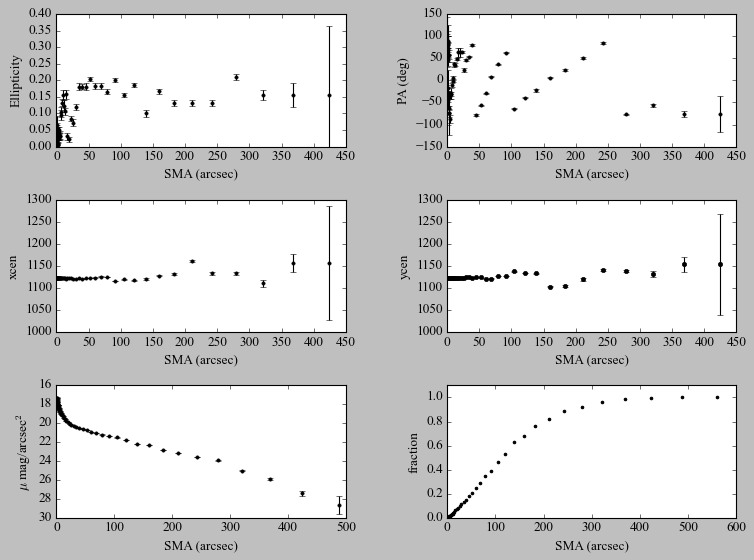

In [15]:
ig = iso_free.stop_code != 4 # 课后有时间再通过上面的链接看看stop code的意义。它有时候可以有效地帮你debug

plt.figure(figsize=(10, 7.5))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.35)

plt.subplot(321) # iso_free.sma 是半长轴，.eps是椭率，.ellip_err是椭率的误差
plt.errorbar(iso_free.sma[ig]*params['pixscl'], iso_free.eps[ig], yerr=iso_free.ellip_err[ig], 
             fmt='o', markersize=3, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('Ellipticity')
plt.ylim(0, 0.4)

plt.subplot(322) # pa是位置角，pa_err是位置角的误差
plt.errorbar(iso_free.sma[ig]*params['pixscl'], iso_free.pa[ig]/np.pi*180.-90, yerr=iso_free.pa_err[ig]/np.pi*180., 
             fmt='o', markersize=3, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('PA (deg)')

plt.subplot(323) # x0，y0是拟合得到的每个isophote的中心，
plt.errorbar(iso_free.sma[ig]*params['pixscl'], iso_free.x0[ig], yerr=iso_free.x0_err[ig], fmt='o', 
             markersize=3, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('xcen')


plt.subplot(324) # x0，y0是拟合得到的每个isophote的中心，
plt.errorbar(iso_free.sma[ig]*params['pixscl'], iso_free.y0[ig], yerr=iso_free.y0_err[ig], fmt='o', 
             markersize=4, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('ycen')

plt.subplot(325) # 画表面亮度轮廓。
kk = iso_free.intens > 0 # 小于等于0的log没有意义
mu = -2.5*np.log10(iso_free.intens[kk]/params['pixscl']**2) + 22.5 # 这里的zero point = 22.5
mu_err = 2.5*iso_free.int_err[kk]/iso_free.intens[kk]/np.log(10)

plt.errorbar(iso_free.sma[kk]*params['pixscl'], mu, yerr=mu_err, color='black', fmt='o', markersize=3)
plt.ylim(30, 16)
plt.ylabel('$\mu$ mag/arcsec$^2$')
plt.xlabel('SMA (arcsec)')


plt.subplot(326) # .tflux_e 是各个isophote圈住的总的像素值，iso_free.tflux_e/np.max(iso_free.tflux_e) 则得到
# 各个isophote圈住的像素值相对于全部像素值的比例，这个曲线被称为curve of growth
plt.scatter(iso_free.sma*params['pixscl'], iso_free.tflux_e/np.max(iso_free.tflux_e), color='black', marker='.')
plt.ylabel('fraction')
plt.xlabel('SMA (arcsec)')
plt.xlim(0, 600)
plt.ylim(0, 1.1)
plt.savefig('iso_step1.png', bbox_inches='tight')

### 对星系中心的坐标在中心附近取平均。

In [20]:
kk = iso_free.sma*params['pixscl'] < 10
xcen = np.mean(iso_free.x0[kk])
ycen = np.mean(iso_free.y0[kk])
params.update({'xcen':xcen, 'ycen':ycen}) # your measured center
print('The galaxy center: ', xcen, ycen) # in pixels

The galaxy center:  1122.0277152872386 1123.0303453001889


In [21]:
w = WCS(hdu.header)
center_sky = w.pixel_to_world(xcen, ycen) # 用头文件的信息将中心的pixel坐标转换为天体坐标
center_sky # RA & DEC

<SkyCoord (ICRS): (ra, dec) in deg
    (24.17396614, 15.78364634)>

In [22]:
24.173946, 15.783662 # from NED (https://ned.ipac.caltech.edu), consistent with our results

(24.173946, 15.783662)

### 在图像中画出isophotes，观测isophotes跟旋臂结构的关联。可以清楚地看到，因为旋臂的影响，isophote被扭曲，其方位角PA倾向于指向旋臂的位置，PA跟随旋臂的变化而变化，由此产生的结果是，isophotes的重叠也描绘出旋臂的形状。但是要注意，这个现象只在旋臂足够对称，旋臂不会两次穿过同一个isophote，的时候才会发生。

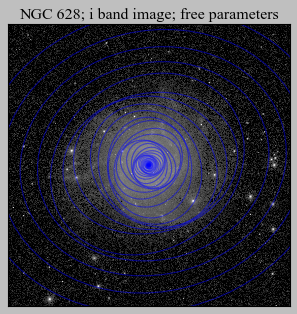

In [13]:
plt.figure(figsize=(10, 5))
ax1=plt.subplot(121)

norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
plt.imshow(img, origin='lower', cmap='Greys_r', norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('NGC 628; i band image; free parameters')
################

Niso = len(iso_free.sma) # 注意！！这里的是patches.Ellipse或者ellipse，跟isophote的Ellipse是不一样的！最好用不一样的符号来表示
for k in range(0, Niso):
    ellipse = patches.Ellipse((iso_free.x0[k], iso_free.y0[k]), 2*iso_free.sma[k], 
                      (1-iso_free.eps[k])*2*iso_free.sma[k], 
                      angle=iso_free.pa[k]*180/np.pi, alpha=0.5, fill=False, color='blue')
    ax1.add_artist(ellipse)

plt.savefig('img_iso_step1.png', bbox_inches='tight')

# 第二次拟合isophotes。这次是为了确定星系的椭率和位置角。

In [23]:
time_start = time.time()
geometry = EllipseGeometry(params['xcen'], params['ycen'], params['sma0'], params['e0'], params['pa0'])

ellipse = Ellipse(img_masked, geometry)

iso_fixCen = ellipse.fit_image(fix_center=True, fix_pa=False, fix_eps=False, 
    minsma=1, maxsma=DIM/2*1.3, step=0.1, maxgerr=1)

time_end = time.time()
print('totally cost: ',int(time_end-time_start)) # 同样地，跑得很慢，pixels太多

totally cost:  294


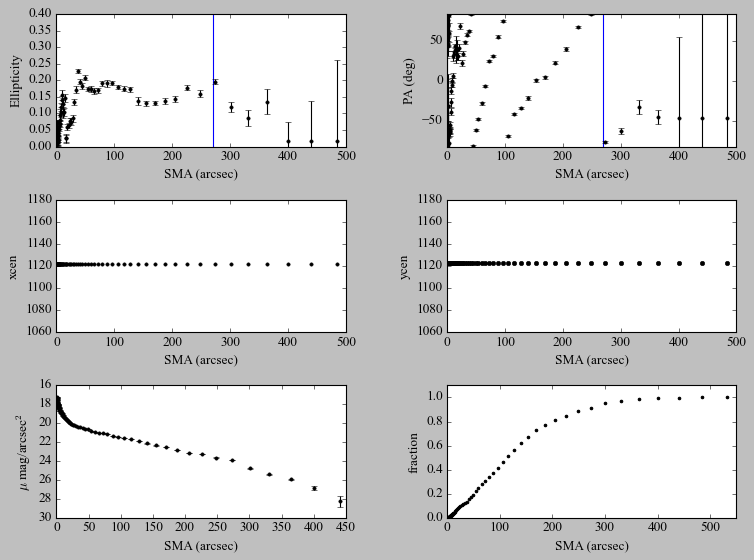

In [28]:
ig = iso_fixCen.stop_code !=4

plt.figure(figsize=(10, 7.5))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.35)

plt.subplot(321) # plot the profile of ellipcity。我们对星系外围的e和pa取平均作为该星系的椭率和位置角。由于我们已经发现，
# 该星系的旋臂会显著影响isophote，因此我们要避开旋臂的影响，选取的范围不要包括被旋臂影响的isophotes。PA在旋臂的影响下不断在增加，
# 那么我们选取PA不再持续增加的范围 sma > 270。
plt.errorbar(iso_fixCen.sma[ig]*params['pixscl'], iso_fixCen.eps[ig], yerr=iso_fixCen.ellip_err[ig], 
             fmt='o', markersize=3, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('Ellipticity')
plt.ylim(0, 0.4)
plt.vlines(270, 0, 0.4, color='blue')


plt.subplot(322) # plot the profile of position angle。我们对星系外围的e和pa取平均作为该星系的椭率和位置角。由于我们已经发现，
# 该星系的旋臂会显著影响isophote，因此我们要避开旋臂的影响，选取的范围不要包括被旋臂影响的isophotes。PA在旋臂的影响下不断在增加，
# 那么我们选取PA不再持续增加的范围 sma > 270。
plt.errorbar(iso_fixCen.sma[ig]*params['pixscl'], iso_fixCen.pa[ig]/np.pi*180.-90, 
             yerr=iso_fixCen.pa_err[ig]/np.pi*180., fmt='o', markersize=3, color='black')
plt.ylim(np.min(iso_fixCen.pa[ig])/np.pi*180.-90, np.max(iso_fixCen.pa[ig])/np.pi*180.-90)
plt.xlabel('SMA (arcsec)')
plt.ylabel('PA (deg)')
plt.vlines(270, np.min(iso_fixCen.pa[ig])/np.pi*180.-90, np.max(iso_fixCen.pa[ig])/np.pi*180.-90, color='blue')


plt.subplot(323) # the center has been fixed. 
plt.errorbar(iso_fixCen.sma[ig]*params['pixscl'], iso_fixCen.x0[ig], fmt='o', 
             markersize=3, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('xcen')


plt.subplot(324) # the center has been fixed. 
plt.errorbar(iso_fixCen.sma[ig]*params['pixscl'], iso_fixCen.y0[ig], fmt='o', 
             markersize=4, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('ycen')

plt.subplot(325)
kk = iso_fixCen.intens > 0
mu = -2.5*np.log10(iso_fixCen.intens[kk]/params['pixscl']**2) + 22.5
mu_err = 2.5*iso_fixCen.int_err[kk]/iso_fixCen.intens[kk]/np.log(10)

plt.errorbar(iso_fixCen.sma[kk]*params['pixscl'], mu, yerr=mu_err, color='black', fmt='o', markersize=3)
plt.ylim(30, 16)
plt.ylabel('$\mu$ mag/arcsec$^2$')
plt.xlabel('SMA (arcsec)')

plt.subplot(326)
plt.scatter(iso_fixCen.sma*params['pixscl'], iso_fixCen.tflux_e/np.max(iso_fixCen.tflux_e), color='black', marker='.')
plt.ylabel('fraction')
plt.xlabel('SMA (arcsec)')
plt.xlim(0, 550)
plt.ylim(0, 1.1)

plt.savefig('iso_step2.png', bbox_inches='tight')


### 对星系外围的e和PA取平均，测量该星系的global e和PA。该星系的旋臂会显著影响isophote，因此我们要避开旋臂的影响，选取的范围不要包括被旋臂影响的isophotes。PA在旋臂的影响下不断在增加， 那么我们选取PA不再持续增加的范围 sma > 270。

In [29]:
kk = (iso_fixCen.stop_code == 0) & (iso_fixCen.sma*params['pixscl'] > 270)
eps = np.mean(iso_fixCen.eps[kk])
eps_err = np.std(iso_fixCen.eps[kk])
pa = np.mean(iso_fixCen.pa[kk]) /np.pi*180. - 90
if pa < 0: # PA默认在0-180之间。
    pa += 180
pa_err = np.std(iso_fixCen.pa[kk]) /np.pi*180.
incl = np.arccos(1-0.11)*180/np.pi
incl_err = 1/np.sqrt(1-(1-0.11)**2)*eps_err*180/np.pi

params.update({'eps':eps, 'eps_err':eps_err, 'pa':pa, 'pa_err':pa_err, 'incl':incl, 'incl_err':incl_err})

In [30]:
params

{'e0': 0.1,
 'pa0': 10,
 'sma0': 200,
 'xcen0': 1123,
 'ycen0': 1123,
 'pixscl': 0.396,
 'xcen': 1122.0277152872386,
 'ycen': 1123.0303453001889,
 'eps': 0.11100542256947248,
 'eps_err': 0.058976663985365135,
 'pa': 126.8568610402149,
 'pa_err': 15.35301741902337,
 'incl': 27.126753117273967,
 'incl_err': 7.410979139113523}

### 第二次拟合isophotes的时候，采用了更小的step=0.1，相比起第一次采用的step=0.15，isophotes明显密集了很多。

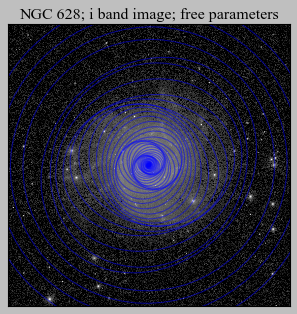

In [18]:
plt.figure(figsize=(10, 5))
ax1=plt.subplot(121)

norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
plt.imshow(img, origin='lower', cmap='Greys_r', norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('NGC 628; i band image; free parameters')
################

Niso = len(iso_fixCen.sma)
for k in range(0, Niso):
    ellipse = patches.Ellipse((iso_fixCen.x0[k], iso_fixCen.y0[k]), 2*iso_fixCen.sma[k], 
                      (1-iso_fixCen.eps[k])*2*iso_fixCen.sma[k], 
                      angle=iso_fixCen.pa[k]*180/np.pi, alpha=0.5, fill=False, color='blue')
    ax1.add_artist(ellipse)

### 以下，是利用拟合出来的isophote重构出星系的图像。这个会跑很久。

In [19]:
model_image = build_ellipse_model(img.shape, iso_fixCen) # 这个程序不应该跑这么久，这里是有优化的空间的。

In [ ]:
fits.writeto('model_image_NGC628.fits', model_image, overwrite=True)

### 以下，是用model image在mask上的值，来填充原图在mask上的位置（原本是foreground stars），从而产生stars-cleaned image

In [22]:
kk = mask == 1
img_clean = copy.deepcopy(img)
img_clean[kk] = model_image[kk]
fits.writeto('clean_image_NGC628.fits', img_clean, overwrite=True)

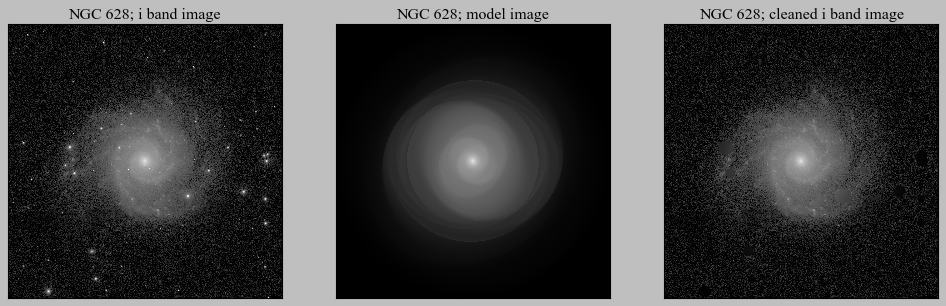

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
plt.imshow(img, origin='lower', cmap='Greys_r', norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('NGC 628; i band image')

plt.subplot(132)
norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
plt.imshow(model_image, origin='lower', cmap='Greys_r', norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('NGC 628; model image')


plt.subplot(133)
norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
plt.imshow(img_clean, origin='lower', cmap='Greys_r', norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('NGC 628; cleaned i band image')

plt.savefig('NGC628_stars_cleaned.png', bbox_inches='tight')

# 第三次“拟合”isophotes来获取其他参数，比如表面亮度轮廓和curve of growth（增长曲线）。之前两次也能得到这两个参数，但是会受到比如中心或epa不确定性的影响，一般papers提到的表面亮度轮廓都是固定了中心，e，pa的（但是也有只固定中心的，结果差别不大）。
### photutils.isophote.Ellipse 并不能同时固定center, ellipticity, and position angle. 显然，所有参数都固定住就不是拟合了。但是我们仍然有固定住所有参数来提取比如表面亮度轮廓的需求，为此，我调用photutils的函数写了一个：extract_fix_isophotes()

In [31]:
extract_fix_isophotes() # 告诉你输入什么参数。默认值：linear_growth=False，用geometric growth的sma，
                        # minsma默认0.5，maxsma默认图片边界，silent=False

syntax: results = extract_fix_isophotes(image=, xcen=, ycen=, initsma=, eps=, pa=, step=, linear_growth=False/True, minsma=None, maxsma=None, silent=False/True; minsma maxsma are optional)


[]

In [25]:
all_fix = extract_fix_isophotes(image=img_clean, xcen=params['xcen'], ycen=params['ycen'], 
                               initsma=20, eps=params['eps'], pa=(params['pa']+90)*np.pi/180, 
                                step=0.1) # 注意PA！！

syntax: results = extract_fix_isophotes(image=, xcen=, ycen=, initsma=, eps=, pa=, step=, linear_growth=False/True, minsma=None, maxsma=None, silent=False/True; minsma maxsma are optional)


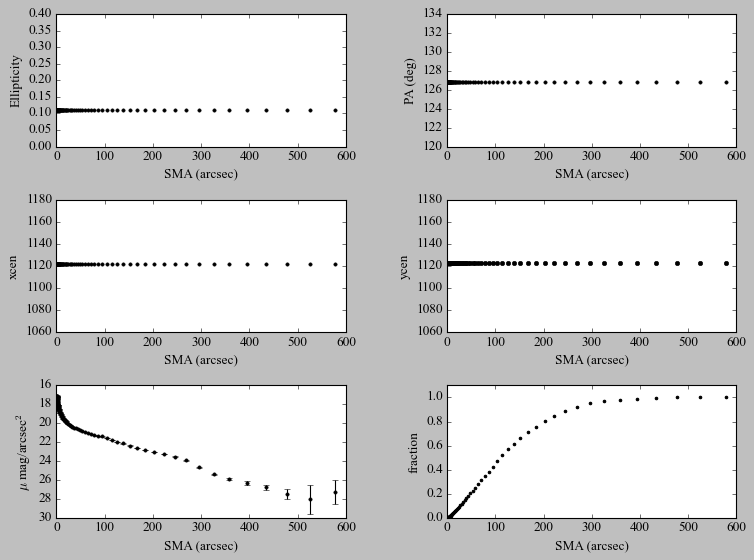

In [26]:
plt.figure(figsize=(10, 7.5))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.35)

plt.subplot(321) # 固定了椭率
plt.errorbar(all_fix.sma*params['pixscl'], all_fix.eps, fmt='o', markersize=3, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('Ellipticity')
plt.ylim(0, 0.4)

plt.subplot(322) # 固定了PA
plt.errorbar( all_fix.sma *params['pixscl'],  all_fix.pa /np.pi*180.-90, 
             fmt='o', markersize=3, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('PA (deg)')

plt.subplot(323) # 固定了中心
plt.errorbar( all_fix.sma *params['pixscl'],  all_fix.x0 ,  fmt='o', 
             markersize=3, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('xcen')


plt.subplot(324) # 固定了中心
plt.errorbar( all_fix.sma *params['pixscl'],  all_fix.y0 , fmt='o', 
             markersize=4, color='black')
plt.xlabel('SMA (arcsec)')
plt.ylabel('ycen')

plt.subplot(325) # 这一部分是第三次拟合主要关注的。
kk =  all_fix.intens > 0
mu = -2.5*np.log10( all_fix.intens[kk]/params['pixscl']**2) + 22.5 # surface brightness profile
mu_err = 2.5* all_fix.int_err[kk]/ all_fix.intens[kk]/np.log(10)
sma_mu = all_fix.sma[kk]*params['pixscl']
plt.errorbar(sma_mu, mu, yerr=mu_err, color='black', fmt='o', markersize=3)
plt.ylim(30, 16)
plt.ylabel('$\mu$ mag/arcsec$^2$')
plt.xlabel('SMA (arcsec)')

cog = all_fix.tflux_e/np.max( all_fix.tflux_e) # curve of growth，经常用来计算星系的size。
sma_cog = all_fix.sma*params['pixscl']
plt.subplot(326)
plt.scatter(sma_cog, cog , color='black', marker='.')
plt.ylabel('fraction')
plt.xlabel('SMA (arcsec)')
plt.xlim(0, 600)
plt.ylim(0, 1.1)
plt.savefig('iso_step3.png', bbox_inches='tight')

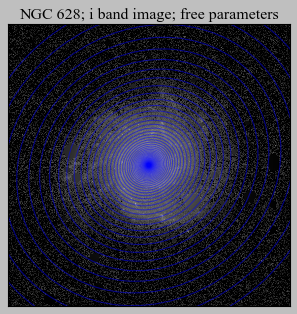

In [27]:
plt.figure(figsize=(10, 5))
ax1=plt.subplot(121)

norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
plt.imshow(img_clean, origin='lower', cmap='Greys_r', norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('NGC 628; i band image; free parameters')
################

Niso = len(all_fix.sma)
for k in range(0, Niso):
    ellipse = patches.Ellipse((all_fix.x0[k], all_fix.y0[k]), 2*all_fix.sma[k], 
                      (1-all_fix.eps[k])*2*all_fix.sma[k], 
                      angle=all_fix.pa[k]*180/np.pi, alpha=0.5, fill=False, color='blue')
    ax1.add_artist(ellipse)
    
plt.savefig('img_iso_step3.png', bbox_inches='tight')

### 测量星系的性质：视星等，绝对星等，大小，星系的光的分布的集中程度：

In [28]:
flux_tot = np.sum(img_clean)
mag = -2.5*np.log10(flux_tot) + 22.5 # 还需要correct galactic extinction, internal extinction and k correction，
                                     # 参考：http://leda.univ-lyon1.fr/leda/param/btc.html
print('apparent magnitude:', mag.round(2), 'AB mag') # AB mag: https://en.wikipedia.org/wiki/AB_magnitude
#############
dist_mod = 30.03 # distance modulus from HyperLeda: http://leda.univ-lyon1.fr/ledacat.cgi?o=NGC628
Mag = mag - dist_mod
print('Absolute magnitude:', Mag.round(2), 'AB mag')
#############
R25 = np.interp(25, mu, sma_mu)
print('projected major axis of a galaxy at the isophotal level 25 mag/arcsec2: ', R25.round(1), 'arcsec')
#############
r50 = np.interp(0.5, cog, sma_cog) # 这就是effective radius或者half light radius，当然，
                                   # 还可以通过对星系进行galfit（之后的课程有）的拟合得到该参数
print('i-band half light radius: ', r50.round(1), 'arcsec')
#############
r20 = np.interp(0.2, cog, sma_cog) # r20, r50, r80 enclose 20%, 50%, 80% of total flux
r80 = np.interp(0.8, cog, sma_cog)
Cindex = 5 * np.log10(r80/r20) # 这个参数越大，星系的flux越往中心集中。
print('concentration index (reflect bulge prominence)', Cindex.round(2))
#############
params.update({'mag':mag.round(2), 'Mag':Mag.round(2), 'R25':R25.round(1), 'r50':r50.round(1), 
               'C':Cindex.round(2)})

apparent magnitude: 8.84 AB mag
Absolute magnitude: -21.19 AB mag
projected major axis of a galaxy at the isophotal level 25 mag/arcsec2:  309.9 arcsec
i-band half light radius:  109.7 arcsec
concentration index (reflect bulge prominence) 3.12


In [ ]:
params